# Анализ ДТП в России на основе данных dtp-stat.ru
Это пример простого анализа статистики ДТП в России.
Посмотрим на следующие свойства данных:
- Структурированность данных
- Чистота данных
- Распределения наблюдаемых значений и признаков
- Корреляция по значений по признакам

## Шаг -1. Загрузка данных в локальные файлы
Этот шаг можно пропустить, если вы уже загружали файлы ранее.

In [ ]:
import requests as r
import os
import aiohttp
from bs4 import BeautifulSoup as bs

links = []
resp = r.get('https://dtp-stat.ru/opendata/')
if resp.ok:
    soup = bs(resp.text, "html.parser")
    for link in soup.findAll('a'):
        url = link.get('href')
        if '.geojson' in url: links.append('https://dtp-stat.ru' + url)
if len(links) == 85:
    print('Все регионы присутствуют на сайте. Загружаем')
else:
    print("Some regions are missed")
async with aiohttp.ClientSession() as session:
    for link in links:
        async with session.get(link) as resp:
            file_name = os.path.basename(link)
            with open('data/dtp-stat/' + file_name, 'w') as f:
                f.write(await resp.text())
                print('.', end='')
print(' готово.', end='')

## Шаг 0. Склейка файлов в один большой
Склеиваем все скачанные geojson файлы в один большой. Понадобится *много*(~15gb) памяти.

Этот шаг стоит выполнить если вы собираетесь анализировать весь массив данных сразу.

In [ ]:
import glob

files = glob.glob('data/dtp-stat/*')
import json

features = []
for file in files:
    with open(file) as f:
        d = json.load(f)
        features.extend(d['features'])
result = {
    "type": "FeatureCollection",
    "features": features
}
with open('data/dtp-stat/russia.geojson', 'w') as f:
    json.dump(result, f, ensure_ascii=False)
del result
del features

## Шаг 1.  Готовим pandas фрейм

Загружаем данные geojson файла в pandas фрейм. Посмотрим на структуру 


In [1]:
import pandas as pd
import json
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
sb.set_context("notebook", font_scale=1.5)

FILE_NAME = 'data/dtp-stat/altaiskii-krai.geojson'

with open(FILE_NAME) as f:
    d = map(lambda x: x['properties'], json.load(f)['features'])
df = pd.DataFrame.from_dict(d)
df.head(2)

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,2311491,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","[Многоквартирные жилые дома, Административные ...",Барнаул,610,"г Барнаул, тракт Павловский, 249 а",[Ясно],Наезд на препятствие,2017-09-04 22:15:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'Ч...",0,[],1,Алтайский край,[Сухое],2,[Все участники]
1,2489516,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,"{'lat': 53.369248, 'long': 83.699802}","[Многоквартирные жилые дома, Нерегулируемый пе...",Барнаул,300,"г Барнаул, ул Юрина, 241",[Дождь],Столкновение,2020-09-24 09:30:00,Легкий,"[{'year': 2006, 'brand': 'SUBARU', 'color': 'С...",0,[],2,Алтайский край,[Мокрое],3,"[Дети, Все участники]"


Предущий шаг загрузил данные в датафрейм в памяти и вывел первые 2 строки фрейма.
## Приберемся в данных
- добавим индекс и метку времени
- списки преобразуем в строки
- строки сделаем категориями
- укоротим текст категорий для читаемости

In [2]:
#Индекс и метка времени
df.set_index('id', inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])
# Размечаем категориальные признаки
for column in ['scheme', 'category', 'severity', 'region', 'parent_region']:
    df[column] = df[column].astype('category')
df['address'] = df['address'].astype('string')
df['category'] = df['category'].cat.rename_categories(
    {
        'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ': 'Наезд на работника',
        'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы': 'Наезд на служащего',
        'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность': 'Наезд на другого',
        'Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.': 'Возгорание на ходу'
     }
)

В наборе данных у нас пока присуствуют три основных показателя
 - `participants_count`
 - `injured_count`
 - `dead_count`
Посмотрим на их распредение по некоторым категорийным данным

### Распределение количества участников, пострадавших и смертей по категории Тяжесть ДТП(severity)

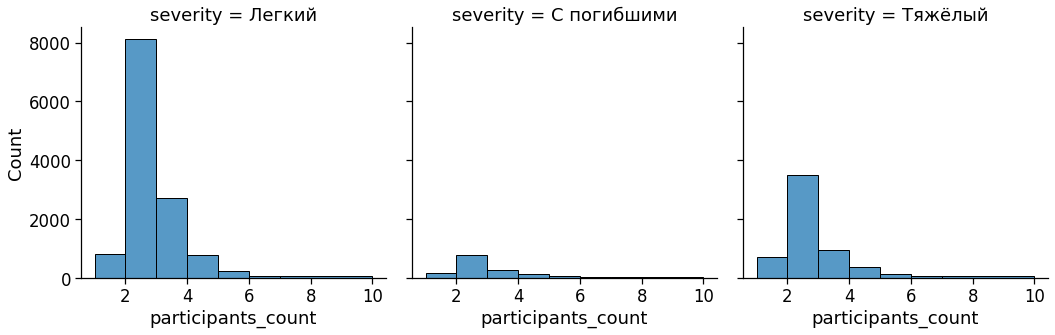

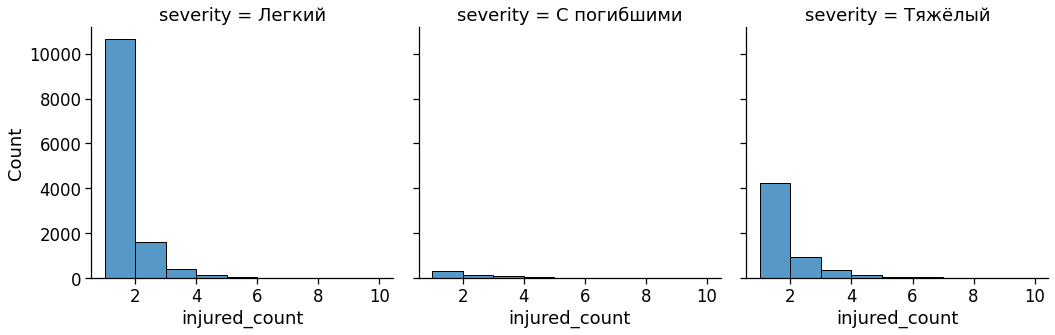

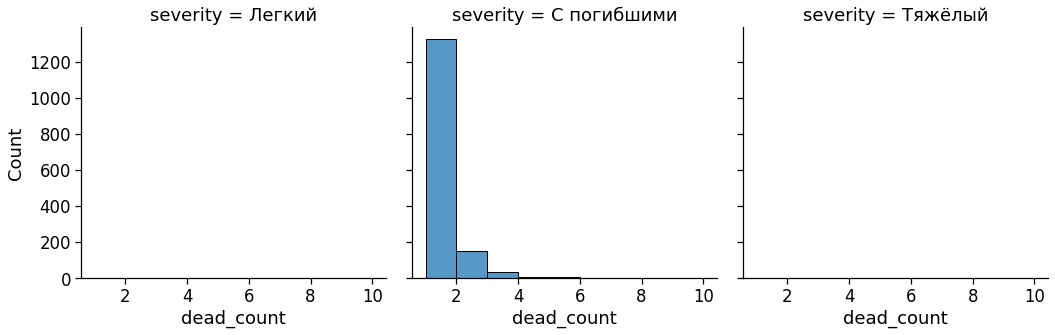

In [3]:
display(Markdown('### Распределение количества участников, пострадавших и смертей по категории Тяжесть ДТП(severity)'))
sb.displot(data = df,  x = 'participants_count', col = 'severity' ,bins=[1, 2, 3, 4, 5, 6,7,10])
sb.displot(data = df,  x = 'injured_count', col = 'severity',bins=[1, 2, 3, 4, 5, 6,7,10] )
sb.displot(data = df,  x = 'dead_count', col = 'severity' ,bins=[1, 2, 3, 4, 5, 6,7,10])
plt.show()

### Смертность по категориям

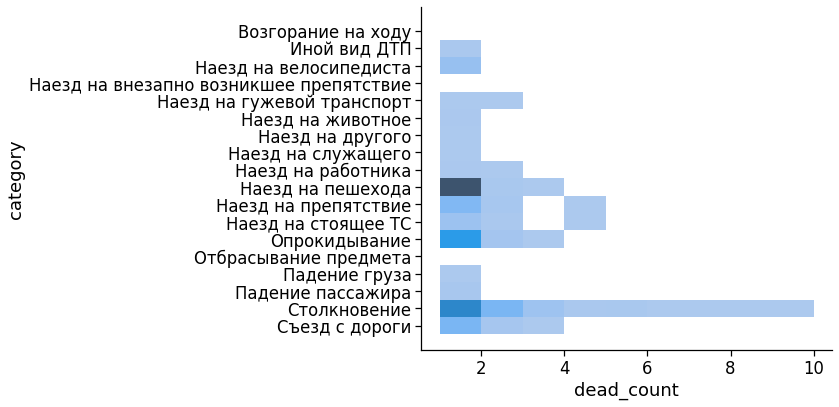

In [4]:
display(Markdown('### Смертность по категориям'))
sb.displot(df, x="dead_count",y = 'category',bins=[1, 2, 3, 4, 5, 6, 10,], aspect=2, height = 6)
plt.show()

### Онтошение смертности к пострадавшим

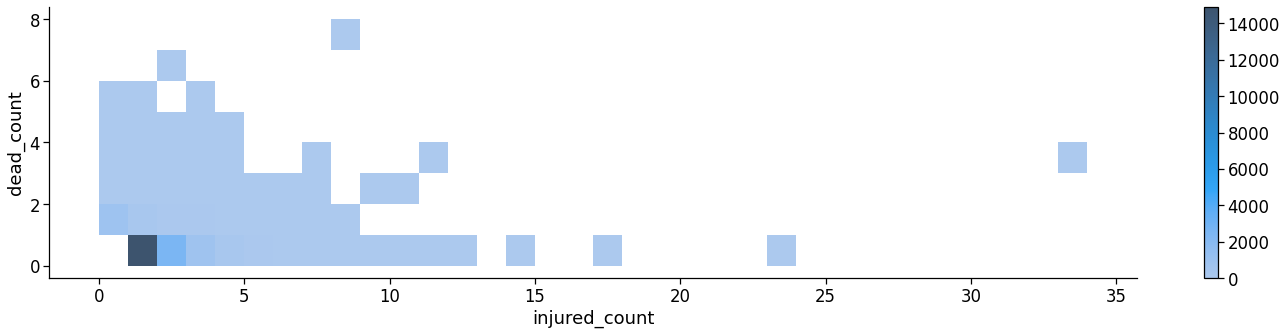

In [5]:
display(Markdown('### Онтошение смертности к пострадавшим'))
sb.displot(df, x="injured_count",y = 'dead_count',binwidth=(1, 1), cbar=True, aspect =4 )
plt.show()

## Примеры похожих исследований на Kaggle
- [https://www.kaggle.com/sobhanmoosavi/us-accidents/tasks](us-accidents)
- [https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales](1.6 million UK traffic accidents)
- [https://www.kaggle.com/amadeus1996/eda-visualizations-for-accidents-in-france](Visualizations for Accidents in France)